In [59]:
import numpy as np
import os
import scipy.stats as st
import scipy
import matplotlib.pyplot as plt
import pickle as pkl
import PGanalysis

In [533]:
def plot_individual_spot_tuning(cell, baseline_sub_psth_by_trial, n_trials, n_latencies_single_spot, filt_width = 5, font_size = 15, ylim=[-10,20],y_step = 10):
    '''
    plot the tuning curves for individual spots as a function of stimulation latency relative to inhalation.
    
    parameters
    ----------
    cell: index of cell to plot
    baseline_sub_psth_by_trial: the trial by trial baseline subtracted psth matrix. Should be n_cells x n_stim x n_trials
    n_trials: number of trials per stimulus
    n_latencies_single_spot: the number of single spot stimulation latencies (should be 15 unique latencies)
    
    outputs
    -------
    plots the tuning curves for spots A and B as a function of latency relative to inhalation
    
    '''
    
    # spot A indices: where spot A was stimulated alone at different intervals relative to inhalation
    spot_A_indices = np.arange(30,45) # hard-coded. 30-45 are spot A alone indices. 
    spot_A_psths = baseline_sub_psth_by_trial[cell,spot_A_indices,:]
    
    # the single spot intervals
    x_single_spot = np.arange(0,75,5)
   
    # initialize a matrix to store smoothed phase-tuning curves for spot A
    mov_mean_spotA = np.empty((n_trials, n_latencies_single_spot))
    for trial in range(n_trials):
        y = spot_A_psths[:,trial]
        mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
        mov_mean_spotA[trial,:] = mov_mean_y

    # calculate the 95% confidence interval for change in firing rate for each trial 
    mean_stim_respA = np.mean(mov_mean_spotA,0)
    CI_A = np.empty(n_latencies_single_spot)
    for stim in range(n_latencies_single_spot):
        t = st.t.interval(alpha=0.95, df=len(mov_mean_spotA[:,stim])-1, loc=np.mean(mov_mean_spotA[:,stim]), scale=st.sem(mov_mean_spotA[:,stim])) 
        CI_A[stim] = (np.abs(mean_stim_respA[stim]-t[0])).T
    
    # plot the tuning curves for spot A  
    plt.plot(x_single_spot, np.mean(mov_mean_spotA,0), '-o', color = 'navy', linewidth = .5)
    plt.errorbar(x_single_spot, np.mean(mov_mean_spotA,0), yerr = CI_A, color = 'b', linewidth = .5)

    # spot B indices: where spot B was stimulated alone at different intervals relative to inhalation
    spot_B_indices = np.arange(45,60) # hard-coded. 45-60 are spot B alone indices. 
    spot_B_psths = baseline_sub_psth_by_trial[cell,spot_B_indices,:]
   
    # initialize a matrix to store smoothed phase-tuning curves for spot B
    mov_mean_spotB = np.empty((n_trials, n_latencies_single_spot))
    for trial in range(n_trials):
        y = spot_B_psths[:,trial]
        mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
        mov_mean_spotB[trial,:] = mov_mean_y

    # calculate the 95% confidence interval for change in firing rate for each trial 
    mean_stim_respB = np.mean(mov_mean_spotB,0)
    CI_B = np.empty(n_latencies_single_spot)
    for stim in range(n_latencies_single_spot):
        t = st.t.interval(alpha=0.95, df=len(mov_mean_spotB[:,stim])-1, loc=np.mean(mov_mean_spotB[:,stim]), scale=st.sem(mov_mean_spotB[:,stim])) 
        CI_B[stim] = (np.abs(mean_stim_respB[stim]-t[0])).T
    
    # plot the tuning curves for spot B 
    plt.plot(x_single_spot, np.mean(mov_mean_spotB,0), '-o', color = 'firebrick', linewidth = .5)
    plt.errorbar(x_single_spot, np.mean(mov_mean_spotB,0), yerr = CI_B, color = 'firebrick', linewidth = .5)
  
    plt.ylim(ylim[0],ylim[1])
    yticks = np.arange(ylim[0],ylim[1]+y_step, y_step)
    plt.yticks(yticks)
    plt.xticks([0,35,70])
    plt.ylabel('$\Delta$ firing rate (Hz)')
    plt.xlabel('Time from \n inhalation (ms)')
    PGanalysis.axis_fixer(ratio = 1, size = font_size)

In [61]:
# load the two spot stimulation data generated using the two-spot processor
os.chdir(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\breath-triggered_sequence_aPCx\two_spot_stim\phase_shift\controls\summary_data')
rec_230225 = np.load('230225_control.npy', allow_pickle = True)[0]
rec_230227 = np.load('230227_control.npy', allow_pickle = True)[0]
rec_230301 = np.load('230301_control.npy', allow_pickle = True)[0]
rec_230302 = np.load('230302_control.npy', allow_pickle = True)[0]
rec_230303 = np.load('230303_control.npy', allow_pickle = True)[0]
rec_230324 = np.load('230324_control.npy', allow_pickle = True)[0]

In [62]:
# make a list of all experiments
reclist = [rec_230225, rec_230227, rec_230301, rec_230302, rec_230303, rec_230324]

In [592]:
# set the indices for each trial type in order from delta t (A-->B) = 70 to delta t (A-->B) = -70
indices = np.concatenate((np.flipud(np.arange(0,15)),np.arange(16,30)))
# set the indices for single spit presentation as a function of time since inhalation
single_spot_indices = np.concatenate((np.flipud(np.arange(30,45)),np.arange(46,60)))

In [593]:
# find cells that are significantly activated by at least one of the delta t conditions
bonf_corr_alpha = .05/len(indices) # bonferroni corrected alpha value 
bonf_corr_act = []
for rec in reclist:
    for cell in range(rec['pvals'].shape[0]):
        if (np.sum((np.where(rec['pvals'][cell,indices]<bonf_corr_alpha)[0]))>0) & (np.sum((np.where(rec['auroc'][cell,indices]>.5)[0]))>0):
            bonf_corr_act.append(1)
        else:
            bonf_corr_act.append(0)

In [594]:
# for each experiment, spike_counts is an n_cells x n_conditions x n_trials matrix containing spike counts over the first 300ms of the trial
spike_counts = rec_230225['spike_counts']
for rec in reclist[1:]:
     spike_counts = np.concatenate((spike_counts, rec['spike_counts']),0)

In [595]:
# perform an anova to identify significantly tuned cells 
tuning = np.empty(spike_counts.shape[0])
tuning_curve_counts = spike_counts[:,indices,:]
# set a label for each trial
labels = np.repeat([indices],spike_counts.shape[2])
for idx, cell in enumerate(tuning_curve_counts):
    tun = PGanalysis.find_temp_tuning(tuning_curve_counts[idx,:,:].ravel(),labels, alpha = .025)
    tuning[idx] = tun

In [596]:
# find cells that are both significantly tuned and significantly activated 
tuned_cells = np.where(~np.isnan(tuning))[0]
resp_cells = np.where(np.array(bonf_corr_act)>0)[0]
tuned_resp_cells = []
for cell in resp_cells:
    if cell in tuned_cells:
        tuned_resp_cells.append(cell)

In [597]:
print('num cells significantly activated = ' + str(len(resp_cells)) + ' out of ' + str(len(bonf_corr_act)))
print('Percentage of cells significantly activated = ' +str(len(np.where(np.array(bonf_corr_act) == 1)[0])/len(bonf_corr_act)*100))
print('num cells significantly tuned = ' + str(len(tuned_resp_cells)) + ' out of ' + str(len(resp_cells)))
print('Percentage of activated cells significantly tuned = ' + str(len(tuned_resp_cells)/len(np.where(np.array(bonf_corr_act) == 1)[0])*100))

num cells significantly activated = 67 out of 521
Percentage of cells significantly activated = 12.859884836852206
num cells significantly tuned = 60 out of 67
Percentage of activated cells significantly tuned = 89.55223880597015


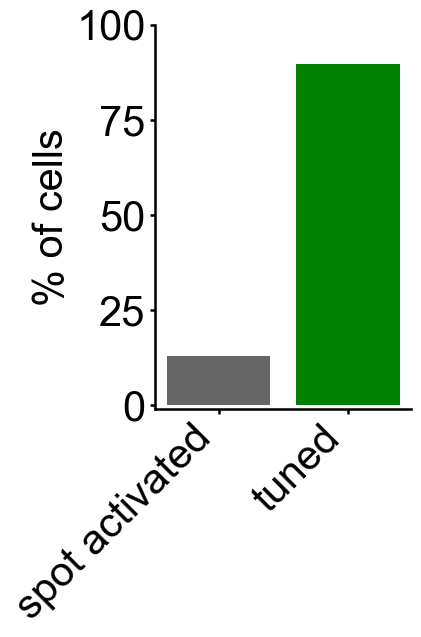

In [545]:
# plot percentage of significantly activated cells (mann whitney U p < .0025) that are tuned (kruskal-wallis p<.01)
percent_activated = len(np.where(np.array(bonf_corr_act) == 1)[0])/len(bonf_corr_act)*100
percent_activated_tuned = len(tuned_resp_cells)/len(np.where(np.array(bonf_corr_act) == 1)[0])*100
color = [[.4,.4,.4],'g']
plt.bar([0,1], [percent_activated, percent_activated_tuned], color = color)
plt.ylim(-1,100)
plt.yticks([0,25,50,75,100])
plt.xticks([0,1], labels = ['spot activated', 'tuned'], rotation = 45, ha = 'right')
plt.ylabel('% of cells')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\percent_cells_activated_tuned.pdf', bbox_inches = 'tight')

In [598]:
# get the baseline subtracted PSTHs and concatenate across experiments
baseline_indices = np.where((rec_230225['PSTH_timepoints']>-.5) & (rec_230225['PSTH_timepoints']<0))[0]
response_indices = np.where((rec_230225['PSTH_timepoints']>-.05) & (rec_230225['PSTH_timepoints']<.3))[0]
baseline_psth = rec_230225['psth_all'][:,:,:,baseline_indices]
baseline_psth_mean_bytrial = np.mean(baseline_psth,3)
baseline_sub_bytrial = np.mean( rec_230225['psth_all'][:,:,:,response_indices],3) - baseline_psth_mean_bytrial
baseline_sub_psth_by_trial = baseline_sub_bytrial
for rec in reclist[1:]:
    baseline_psth = rec['psth_all'][:,:,:,baseline_indices]
    baseline_psth_mean_bytrial = np.mean(baseline_psth,3)
    baseline_sub_bytrial = np.mean(rec['psth_all'][:,:,:,response_indices],3) - baseline_psth_mean_bytrial
    baseline_sub_psth_by_trial = np.concatenate((baseline_sub_psth_by_trial, baseline_sub_bytrial),0)

In [599]:
n_trials = baseline_sub_psth_by_trial.shape[2]
n_latencies_two_spot = len(indices)
n_latencies_single_spot = 15

In [336]:
def plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_latencies_two_spot, filt_width = 5, font_size = 15, ylim = [-10,20], y_step = 10):
    
    # spot A indices: where spot A was stimulated alone at different intervals relative to inhalation
    spot_A_indices = np.arange(30,45) # hard-coded. 30-45 are spot A alone indices. 
    spot_A_psths = baseline_sub_psth_by_trial[cell,spot_A_indices,:]
    
    
    test = baseline_sub_psth_by_trial[cell,:,:]
    test = test[indices,:]
    all_mov_mean_y = np.empty((n_trials,n_latencies_two_spot))
    all_mov_mean_y_combine = np.empty((n_trials,n_latencies_two_spot))
    x_valid = np.arange(-70,75,5)
    filt_width = 5

    single_spot_indices_flip = np.concatenate((np.zeros(14)+30, np.zeros(15)+45)).astype(int)

    test_move = baseline_sub_psth_by_trial[cell,:]
    test_move = test_move[np.flipud(single_spot_indices),:]

    test_static = baseline_sub_psth_by_trial[cell,:,:]
    test_static = test_static[single_spot_indices_flip,:]

    test_all = test_move+test_static

    for trial in range(n_trials):
        y = test[:,trial]
        y_combine = test_all[:,trial]
        mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
        mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')

        all_mov_mean_y[trial,:] = mov_mean_y
        all_mov_mean_y_combine[trial,:] = mov_mean_y_combine

    mean_stim_resp = np.mean(all_mov_mean_y,0)
    mean_stim_resp_combine = np.mean(all_mov_mean_y_combine,0)
    CI = []
    CI_combine = []
    for stim in range(n_latencies_two_spot):
        data = all_mov_mean_y[:,stim]
        data_combine = all_mov_mean_y_combine[:,stim]
        t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
        t2 = np.abs(mean_stim_resp[stim]-t)
        CI.append(t2)
        t_combine = st.t.interval(alpha=0.95, df=len(data_combine)-1, loc=np.mean(data_combine), scale=st.sem(data_combine)) 
        t2_combine = np.abs(mean_stim_resp_combine[stim]-t_combine)
        CI_combine.append(t2)
    CI = np.array(CI)
    CI_combine = np.array(CI_combine)

    plt.plot(x_valid, np.mean(all_mov_mean_y,0), '-ko', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y,0), yerr = CI.T, color = 'k', linewidth = .5)
    plt.plot(x_valid, np.mean(all_mov_mean_y_combine,0), '-mo', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y_combine,0), yerr = CI_combine.T, color = 'purple', linewidth = .5)
    plt.ylim(ylim[0],ylim[1])
    plt.xticks([-70,-35,0,35,70])
    yticks = np.arange(ylim[0],ylim[1]+y_step, y_step)
    plt.yticks(yticks)
    plt.ylabel('$\Delta$ firing rate (Hz)')
    plt.xlabel('$t_{a}-t_{b}$ (ms)')
    plt.title(str(cell))
    PGanalysis.axis_fixer(ratio = 1, size = font_size)

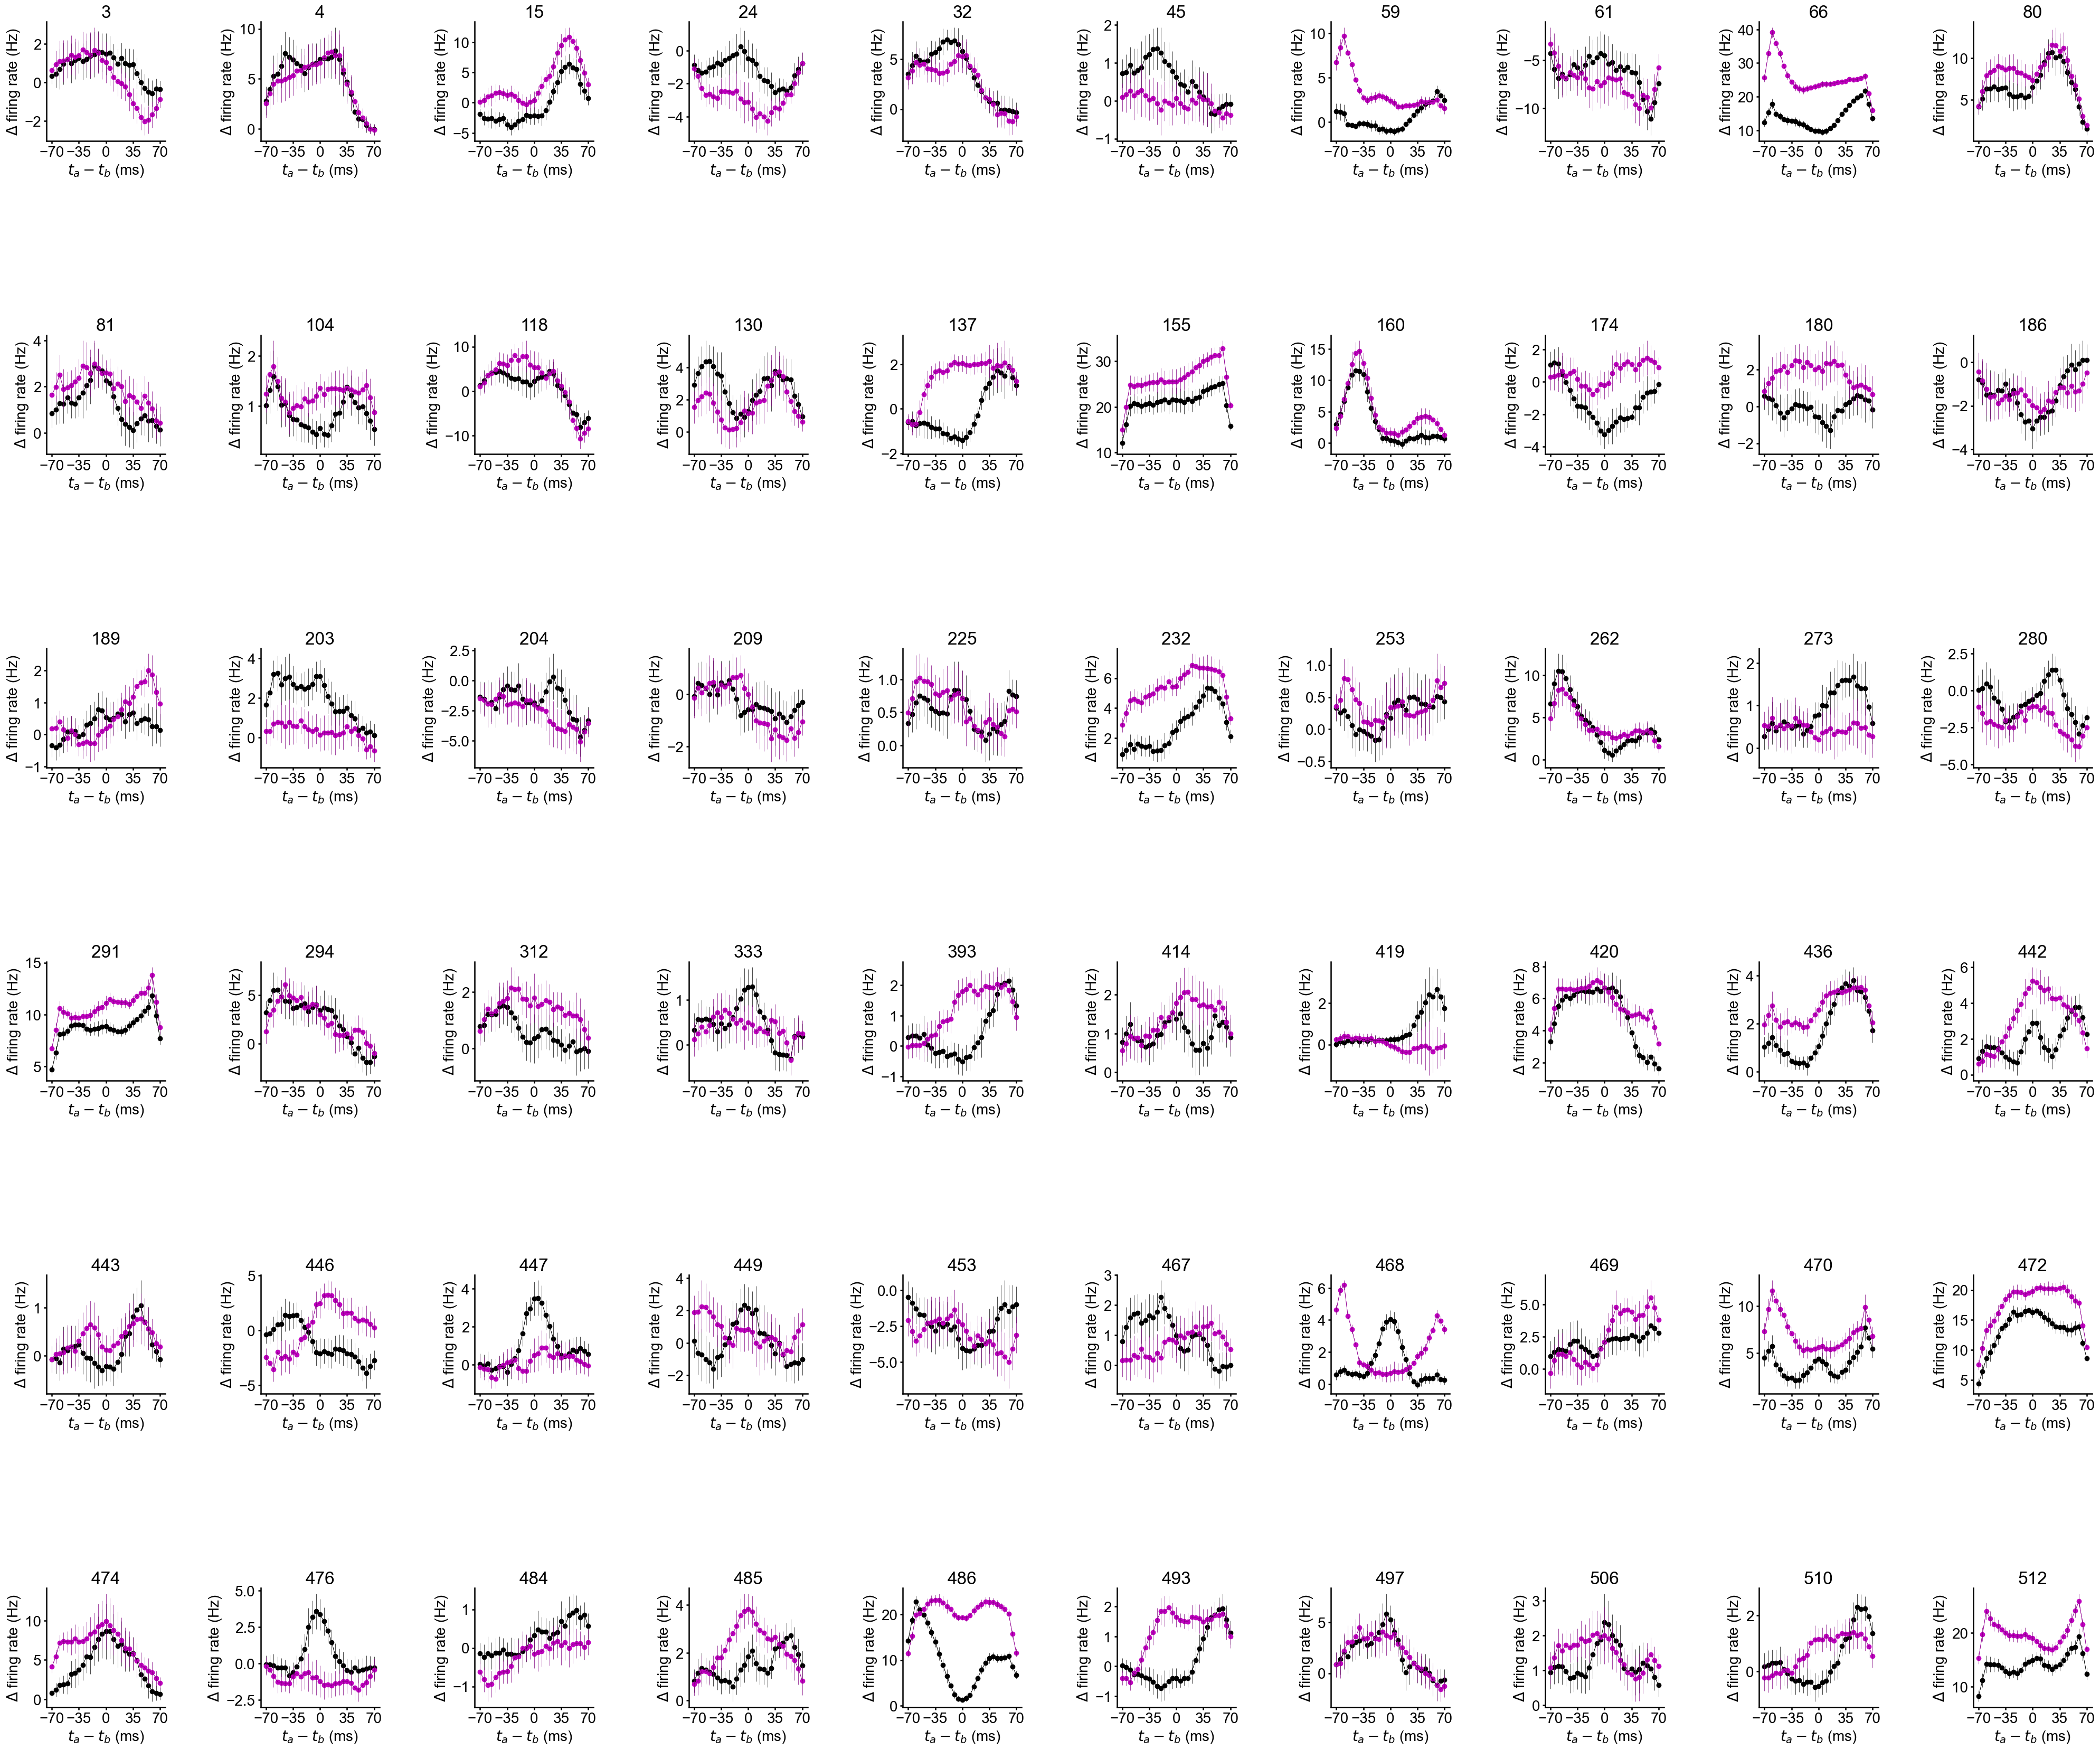

In [436]:
# plot all observed and predicted tuning curves for tuned and responsive cells 

plt.figure(figsize = (50,50))
for cell_n, cell in enumerate(tuned_resp_cells):
    
    plt.subplot(7,10,cell_n+1)
    
    test = baseline_sub_psth_by_trial[cell,:,:]
    test = test[indices,:]
    all_mov_mean_y = np.empty((n_trials,n_latencies_two_spot))
    all_mov_mean_y_combine = np.empty((n_trials,n_latencies_two_spot))
    x_valid = np.arange(-70,75,5)
    filt_width = 5

    single_spot_indices_flip = np.concatenate((np.zeros(14)+30, np.zeros(15)+45)).astype(int)

    test_move = baseline_sub_psth_by_trial[cell,:]
    test_move = test_move[np.flipud(single_spot_indices),:]

    test_static = baseline_sub_psth_by_trial[cell,:,:]
    test_static = test_static[single_spot_indices_flip,:]

    test_all = test_move+test_static

    for trial in range(n_trials):
        y = test[:,trial]
        y_combine = test_all[:,trial]
        mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
        mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')

        all_mov_mean_y[trial,:] = mov_mean_y
        all_mov_mean_y_combine[trial,:] = mov_mean_y_combine

    mean_stim_resp = np.mean(all_mov_mean_y,0)
    mean_stim_resp_combine = np.mean(all_mov_mean_y_combine,0)
    CI = []
    CI_combine = []
    for stim in range(n_latencies_two_spot):
        data = all_mov_mean_y[:,stim]
        data_combine = all_mov_mean_y_combine[:,stim]
        t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
        t2 = np.abs(mean_stim_resp[stim]-t)
        CI.append(t2)
        t_combine = st.t.interval(alpha=0.95, df=len(data_combine)-1, loc=np.mean(data_combine), scale=st.sem(data_combine)) 
        t2_combine = np.abs(mean_stim_resp_combine[stim]-t_combine)
        CI_combine.append(t2)
    CI = np.array(CI)
    CI_combine = np.array(CI_combine)

    plt.title(str(cell))
    plt.plot(x_valid, np.mean(all_mov_mean_y,0), '-ko', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y,0), yerr = CI.T, color = 'k', linewidth = .5)
    plt.plot(x_valid, np.mean(all_mov_mean_y_combine,0), '-mo', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y_combine,0), yerr = CI_combine.T, color = 'purple', linewidth = .5)

    plt.xticks([-70,-35,0,35,70])
    
    plt.ylabel('$\Delta$ firing rate (Hz)')
    plt.xlabel('$t_{a}-t_{b}$ (ms)')
    PGanalysis.axis_fixer(ratio = 1, size = 20)

In [204]:
all_trial_type_psth = reclist[0]['trial_type_psth']
for rec in range(1, len(reclist)):
    all_trial_type_psth = np.concatenate((all_trial_type_psth,  reclist[rec]['trial_type_psth']),0)

In [205]:
all_trial_type_psth.shape

(521, 65, 20, 1500)

In [ ]:
476

meta NOT subset; don't know how to subset; dropped


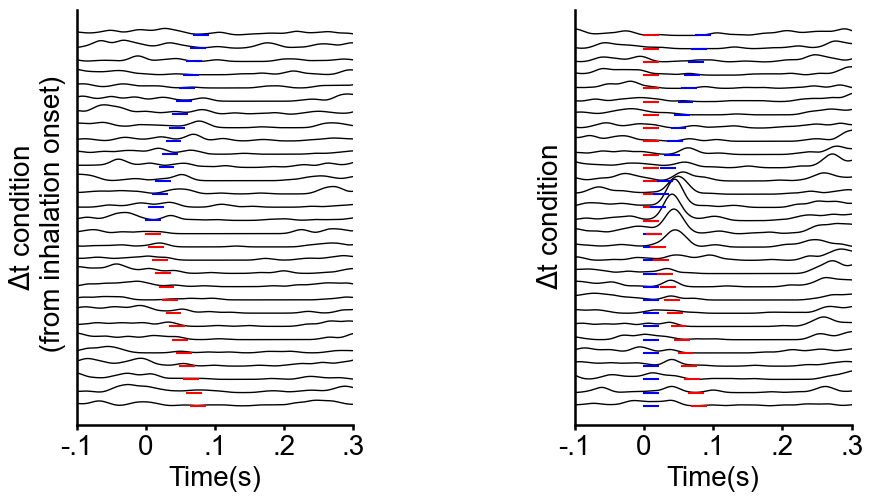

In [512]:
PSTH_timepoints = np.arange(-1,2,.002)
stim_list = indices
fig = plt.figure(figsize=(10,10))
fontsize = 20
cell = 476 #472 #32
mouse = 0
ax = plt.gca()
tn = 0
j = np.arange(0,20)
offset = 0
plt.subplot(1,2,2)
for i in stim_list:
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    #ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    plt.plot(PSTH_timepoints, np.mean(all_trial_type_psth[cell][i],0)+offset, color = color, linewidth = 1)
    if i<=14:
        plt.plot([0,.02],[offset,offset],'b')
        plt.plot([(.005*i),(.005*i)+.02],[offset,offset],'r')
    if i>14:
        plt.plot([0,.02],[offset,offset],'r')
        plt.plot([(.005*i)-(.005*14),((.005*i)+.02)-.005*14],[offset,offset],'b')

    j+=20
    offset+=20
plt.yticks([])
plt.xlim(-.1,.3)
plt.xticks(np.arange(-.1,.4,.1), labels = ['-.1','0','.1','.2','.3'])
plt.ylabel('$\Delta$t condition')
plt.xlabel('Time(s)')
PGanalysis.axis_fixer(ratio = 1.5, size = 20)
    

plt.subplot(1,2,1)
stim_list = np.flipud(single_spot_indices)
tn = 0
j = np.arange(0,20)
offset = 0
for i in stim_list:
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    #ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    plt.plot(PSTH_timepoints, np.mean(all_trial_type_psth[cell][i],0)+offset, color = color, linewidth = 1)
    if i<=44:
        plt.plot([(.005*(i-30)),(.005*(i-30))+.02],[offset,offset],'b')
    if i>44:
        plt.plot([(.005*(i-32))-(.005*14),((.005*(i-32))+.02)-.005*14],[offset,offset],'r')
    plt.yticks([])
    #tn+=1
    
    j+=20
    offset+=20
plt.xlim(-.1,.3)
plt.xticks(np.arange(-.1,.4,.1), labels = ['-.1','0','.1','.2','.3'])
plt.ylabel('$\Delta$t condition \n (from inhalation onset)')
plt.xlabel('Time(s)')
PGanalysis.axis_fixer(ratio = 1.5, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\example_psth_cell476.pdf', bbox_inches = 'tight')

0.0007411135383323941


meta NOT subset; don't know how to subset; dropped


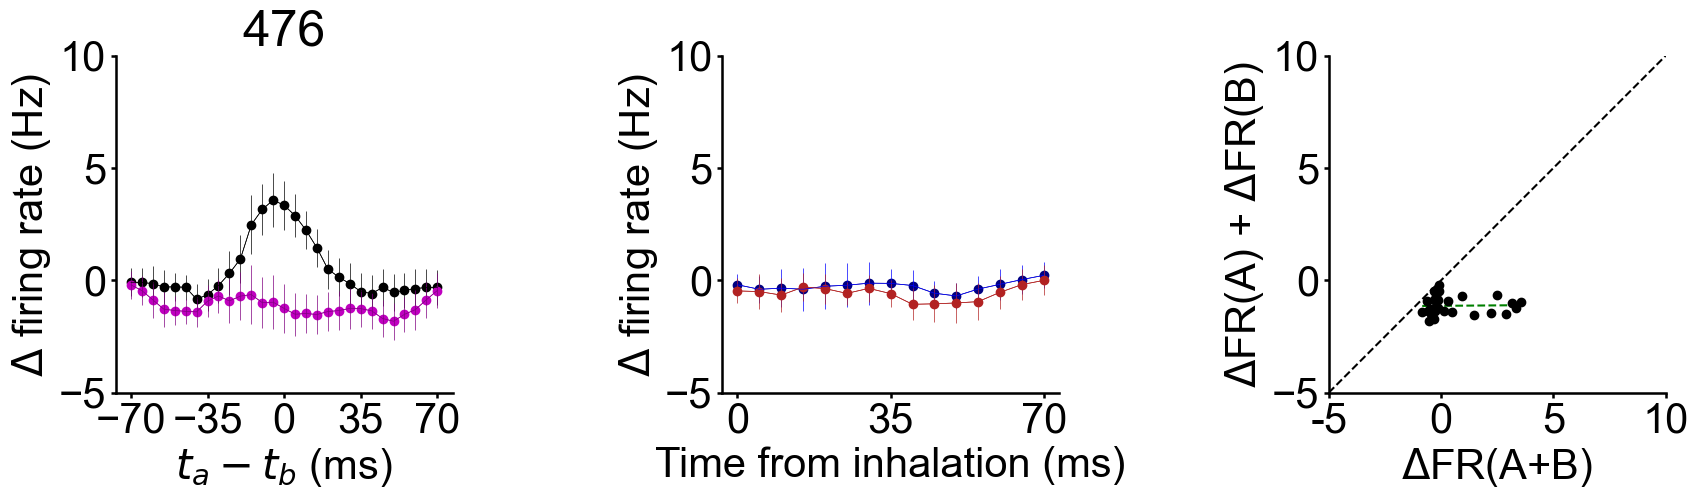

In [520]:
plt.figure(figsize = (20,20))
cell = 476
for cell_n, cell in enumerate([cell]):
    plt.subplot(1,3,1)
    plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_latencies_two_spot, font_size = 30, ylim = [-5,10], y_step = 5)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]

for cell_n, cell in enumerate([cell]):
    plt.subplot(1,3,2)
    plot_individual_spot_tuning(cell, baseline_sub_psth_by_trial, n_trials, n_latencies_single_spot, font_size = 30, ylim = [-5,10], y_step = 5)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]

for i, cell in enumerate([cell]): 
    
    # get the tuning curve for each cell, and smooth it using a moving average over 25 ms.
    y = baseline_sub_mean_psth[cell,indices]
    mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
    
    # get the predicted tuning curve by summing the responses to the single spot stimuli at each delta t condition 
    y_combine = baseline_sub_mean_psth[cell,np.flipud(single_spot_indices)]+baseline_sub_mean_psth[cell,single_spot_indices_flip]
    mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')
    
plt.subplot(1,3,3)    
plt.plot(mov_mean_y, mov_mean_y_combine, 'ko')
coeffs = np.polyfit(mov_mean_y, mov_mean_y_combine,1)
x_vals =np.arange(np.min(mov_mean_y), np.max(mov_mean_y),.001)
plt.plot(x_vals, coeffs[0]*x_vals + coeffs[1],'g--', zorder = 1)
ss_tot = np.sum((mov_mean_y_combine - np.mean(mov_mean_y_combine))**2)
ss_res = np.sum((mov_mean_y_combine-(coeffs[0]*mov_mean_y + coeffs[1]))**2)
r_sq_example = 1 -(ss_res/ss_tot)
plt.ylim(-5,10)
plt.xlim(-5,10)
plt.xticks([-5,0,5,10], labels = ['-5','0','5','10'])
plt.plot([-5,10],[-5,10],'k--')
plt.ylabel('$\Delta$FR(A) + $\Delta$FR(B)')
plt.xlabel('$\Delta$FR(A+B)')
PGanalysis.axis_fixer(ratio = 1, size = 30)
print(r_sq_example)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\example_tuning_cell476.pdf', bbox_inches = 'tight')

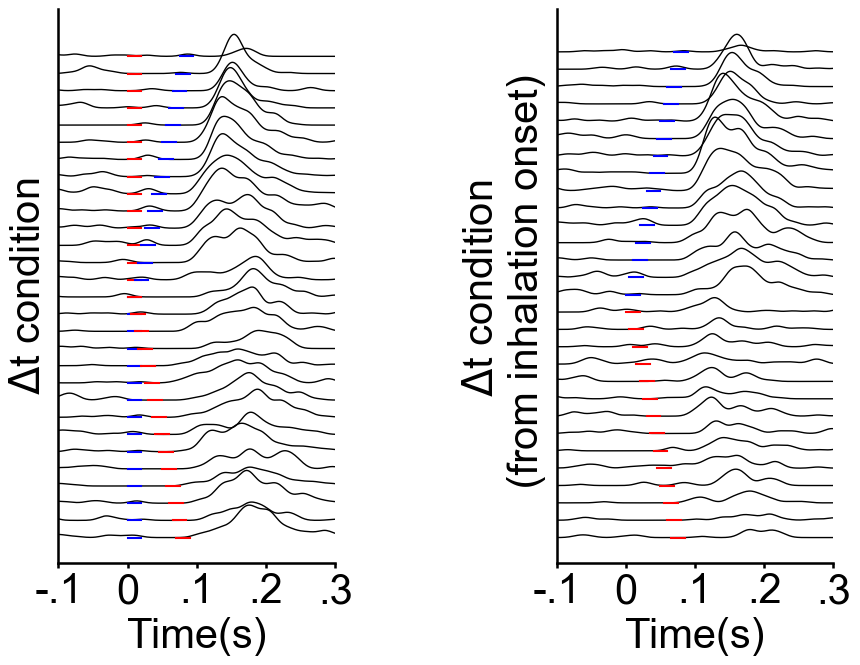

In [479]:
PSTH_timepoints = np.arange(-1,2,.002)
stim_list = indices
fig = plt.figure(figsize=(10,10))
fontsize = 20
cell = 80 #472 #32
mouse = 0
ax = plt.gca()
tn = 0
j = np.arange(0,20)
offset = 0
plt.subplot(1,2,1)
for i in stim_list:
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    #ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    plt.plot(PSTH_timepoints, np.mean(all_trial_type_psth[cell][i],0)+offset, color = color, linewidth = 1)
    if i<=14:
        plt.plot([0,.02],[offset,offset],'b')
        plt.plot([(.005*i),(.005*i)+.02],[offset,offset],'r')
    if i>14:
        plt.plot([0,.02],[offset,offset],'r')
        plt.plot([(.005*i)-(.005*14),((.005*i)+.02)-.005*14],[offset,offset],'b')

    j+=20
    offset+=20
plt.yticks([])
plt.xlim(-.1,.3)
plt.xticks(np.arange(-.1,.4,.1), labels = ['-.1','0','.1','.2','.3'])
plt.ylabel('$\Delta$t condition')
plt.xlabel('Time(s)')
PGanalysis.axis_fixer(ratio = 2, size = 30)
    

plt.subplot(1,2,2)
stim_list = np.flipud(single_spot_indices)
tn = 0
j = np.arange(0,20)
offset = 0
for i in stim_list:
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    #ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    plt.plot(PSTH_timepoints, np.mean(all_trial_type_psth[cell][i],0)+offset, color = color, linewidth = 1)
    if i<=44:
        plt.plot([(.005*(i-30)),(.005*(i-30))+.02],[offset,offset],'b')
    if i>44:
        plt.plot([(.005*(i-32))-(.005*14),((.005*(i-32))+.02)-.005*14],[offset,offset],'r')
    plt.yticks([])
    #tn+=1
    
    j+=20
    offset+=20
plt.xlim(-.1,.3)
plt.xticks(np.arange(-.1,.4,.1), labels = ['-.1','0','.1','.2','.3'])
plt.ylabel('$\Delta$t condition \n (from inhalation onset)')
plt.xlabel('Time(s)')
PGanalysis.axis_fixer(ratio = 2, size = 30)

0.8022149261071922


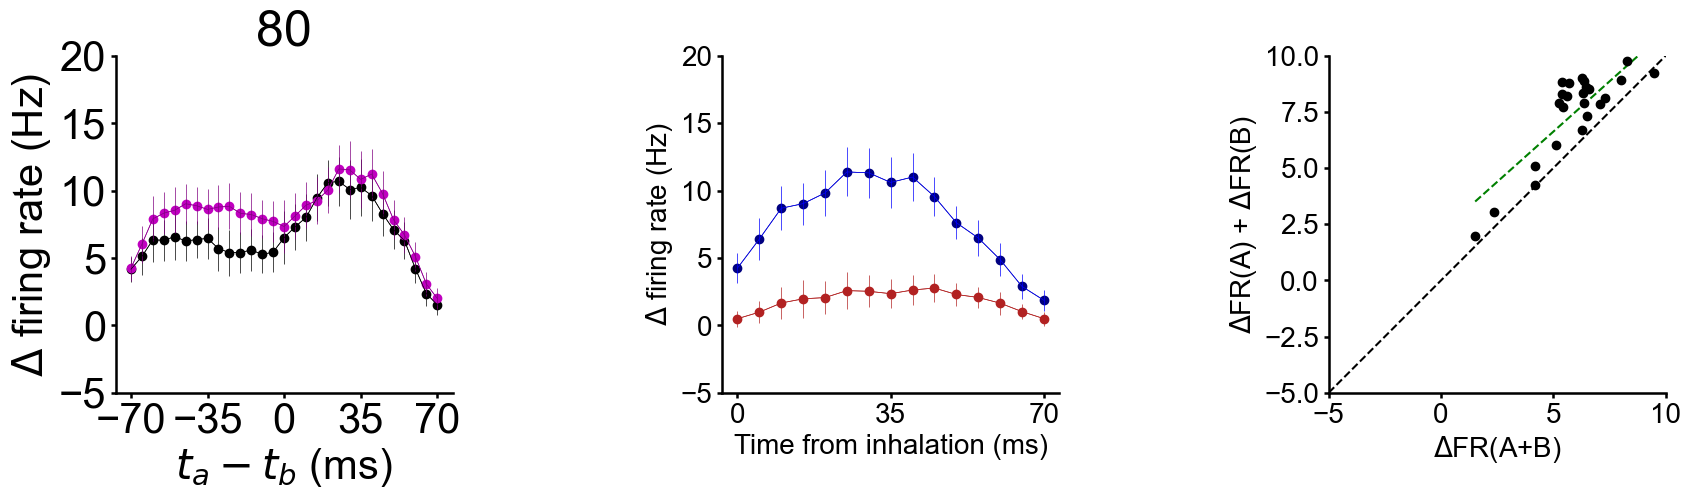

In [462]:
plt.figure(figsize = (20,20))
cell = 80
for cell_n, cell in enumerate([cell]):
    plt.subplot(1,3,1)
    plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_latencies_two_spot, font_size = 20, ylim = [-5,20], y_step = 5)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]

for cell_n, cell in enumerate([cell]):
    plt.subplot(1,3,2)
    plot_individual_spot_tuning(cell, baseline_sub_psth_by_trial, n_trials, n_latencies_single_spot, font_size = 20, ylim = [-5,20], y_step = 5)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]

for i, cell in enumerate([cell]): 
    
    # get the tuning curve for each cell, and smooth it using a moving average over 25 ms.
    y = baseline_sub_mean_psth[cell,indices]
    mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
    
    # get the predicted tuning curve by summing the responses to the single spot stimuli at each delta t condition 
    y_combine = baseline_sub_mean_psth[cell,np.flipud(single_spot_indices)]+baseline_sub_mean_psth[cell,single_spot_indices_flip]
    mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')
    
plt.subplot(1,3,3)    
plt.plot(mov_mean_y, mov_mean_y_combine, 'ko')
coeffs = np.polyfit(mov_mean_y, mov_mean_y_combine,1)
x_vals =np.arange(np.min(mov_mean_y), np.max(mov_mean_y),.001)
plt.plot(x_vals, coeffs[0]*x_vals + coeffs[1],'g--', zorder = 1)
ss_tot = np.sum((mov_mean_y_combine - np.mean(mov_mean_y_combine))**2)
ss_res = np.sum((mov_mean_y_combine-(coeffs[0]*mov_mean_y + coeffs[1]))**2)
r_sq_example = 1 -(ss_res/ss_tot)
plt.ylim(-5,10)
plt.xlim(-5,10)
plt.plot([-5,10],[-5,10],'k--')
plt.ylabel('$\Delta$FR(A) + $\Delta$FR(B)')
plt.xlabel('$\Delta$FR(A+B)')
PGanalysis.axis_fixer(ratio = 1, size = 20)
print(r_sq_example)

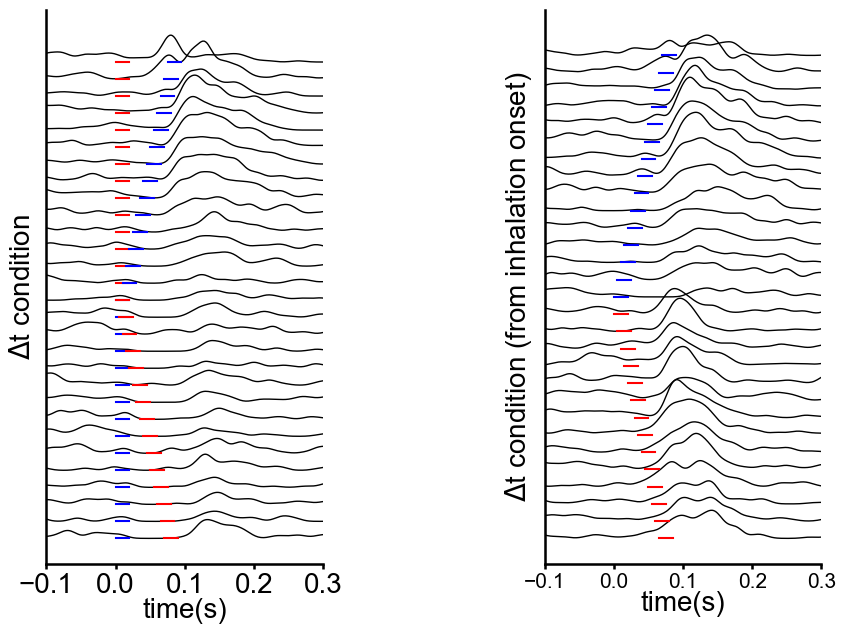

In [467]:
PSTH_timepoints = np.arange(-1,2,.002)
stim_list = indices
fig = plt.figure(figsize=(10,10))
fontsize = 20
cell = 15 #81
mouse = 0
ax = plt.gca()
tn = 0
j = np.arange(0,20)
offset = 0
plt.subplot(1,2,1)
for i in stim_list:
    ax = plt.gca()
    ax.set_ylabel('$\Delta$t condition', fontsize = fontsize)
    ax.set_xlabel('time(s)', fontsize = fontsize, labelpad = -1)
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    #ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    ax.plot(PSTH_timepoints, np.mean(all_trial_type_psth[cell][i],0)+offset, color = color, linewidth = 1)
    if i<=14:
        plt.plot([0,.02],[offset,offset],'b')
        plt.plot([(.005*i),(.005*i)+.02],[offset,offset],'r')
    if i>14:
        plt.plot([0,.02],[offset,offset],'r')
        plt.plot([(.005*i)-(.005*14),((.005*i)+.02)-.005*14],[offset,offset],'b')
    ax.set_yticks([])
    PGanalysis.axis_fixer(ratio = 2)
    #tn+=1
    plt.xlim(-.1,.3)
    j+=20
    offset+=20

plt.subplot(1,2,2)
stim_list = np.flipud(single_spot_indices)
tn = 0
j = np.arange(0,20)
offset = 0
for i in stim_list:
    ax = plt.gca()
    ax.set_ylabel('$\Delta$t condition (from inhalation onset)', fontsize = fontsize)
    ax.set_xlabel('time(s)', fontsize = fontsize, labelpad = -1)
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    #ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    ax.plot(PSTH_timepoints, np.mean(all_trial_type_psth[cell][i],0)+offset, color = color, linewidth = 1)
    if i<=44:
        plt.plot([(.005*(i-30)),(.005*(i-30))+.02],[offset,offset],'b')
    if i>44:
        plt.plot([(.005*(i-32))-(.005*14),((.005*(i-32))+.02)-.005*14],[offset,offset],'r')
    ax.set_yticks([])
    PGanalysis.axis_fixer(ratio = 2)
    #tn+=1
    plt.xlim(-.1,.3)
    j+=20
    offset+=20

0.9426739146105939


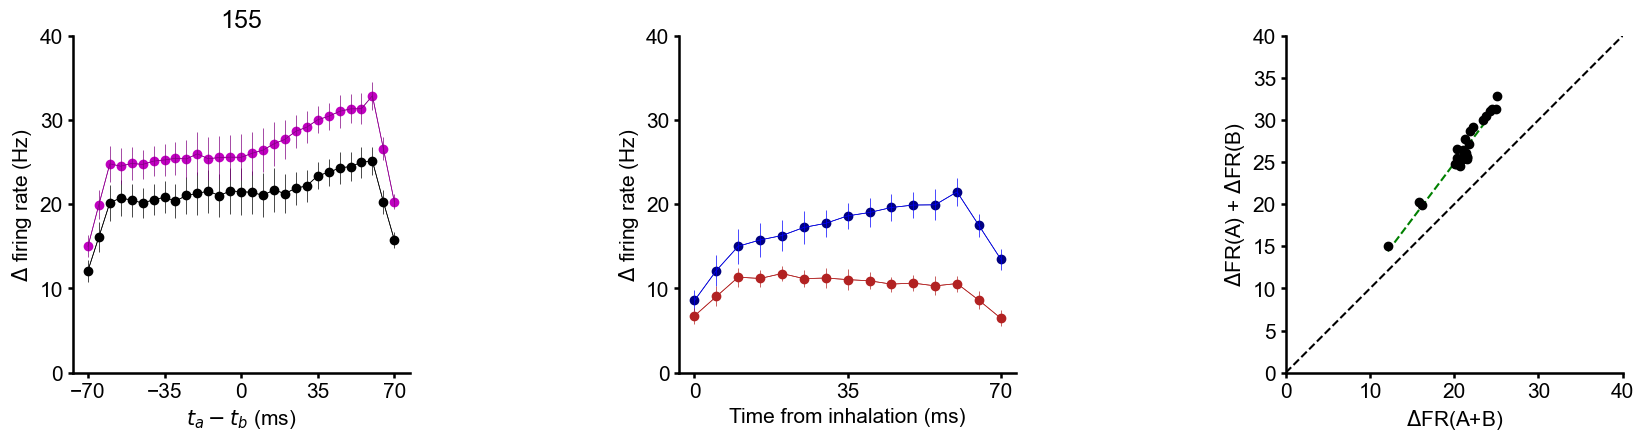

In [468]:
plt.figure(figsize = (20,20))
for cell_n, cell in enumerate([155]):
    plt.subplot(1,3,1)
    plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_latencies_two_spot, font_size = 15, ylim = [0,40])
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]

for cell_n, cell in enumerate([155]):
    plt.subplot(1,3,2)
    plot_individual_spot_tuning(cell, baseline_sub_psth_by_trial, n_trials, n_latencies_single_spot, font_size = 15, ylim = [0,40])
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]

for i, cell in enumerate([155]): 
    
    # get the tuning curve for each cell, and smooth it using a moving average over 25 ms.
    y = baseline_sub_mean_psth[cell,indices]
    mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
    
    # get the predicted tuning curve by summing the responses to the single spot stimuli at each delta t condition 
    y_combine = baseline_sub_mean_psth[cell,np.flipud(single_spot_indices)]+baseline_sub_mean_psth[cell,single_spot_indices_flip]
    mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')
    
plt.subplot(1,3,3)    
plt.plot(mov_mean_y, mov_mean_y_combine, 'ko')
coeffs = np.polyfit(mov_mean_y, mov_mean_y_combine,1)
x_vals =np.arange(np.min(mov_mean_y), np.max(mov_mean_y),.001)
plt.plot(x_vals, coeffs[0]*x_vals + coeffs[1],'g--', zorder = 1)
ss_tot = np.sum((mov_mean_y_combine - np.mean(mov_mean_y_combine))**2)
ss_res = np.sum((mov_mean_y_combine-(coeffs[0]*mov_mean_y + coeffs[1]))**2)
r_sq_example = 1 -(ss_res/ss_tot)
plt.ylim(0,40)
plt.xlim(0,40)
plt.plot([0,40],[0,40],'k--')
plt.ylabel('$\Delta$FR(A) + $\Delta$FR(B)')
plt.xlabel('$\Delta$FR(A+B)')
PGanalysis.axis_fixer(ratio = 1)
print(r_sq_example)

In [263]:
cell_idx

(array([15], dtype=int64),)

In [259]:
cell_idx

(array([], dtype=int64),)

In [600]:
baseline_sub_mean_psth = np.mean(baseline_sub_psth_by_trial,2)

In [626]:
filt_width = 5 #each delta t is 5ms, so smoothing will occur over 25ms

coeffs = np.empty((len(tuned_resp_cells),2))
r_sq = np.empty(len(tuned_resp_cells))

mov_mean_y_all = np.empty((len(tuned_resp_cells), n_latencies_two_spot))
mov_mean_y_combine_all = np.empty((len(tuned_resp_cells), n_latencies_two_spot))
y_all = np.empty((len(tuned_resp_cells), n_latencies_two_spot))
y_combine_all = np.empty((len(tuned_resp_cells), n_latencies_two_spot))

for i, cell in enumerate(tuned_resp_cells): 
    
    # get the tuning curve for each cell, and smooth it using a moving average over 25 ms.
    y = baseline_sub_mean_psth[cell,indices]
    mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
    mov_mean_y_all[i,:] = mov_mean_y
    y_all[i,:] = y
    
    # get the predicted tuning curve by summing the responses to the single spot stimuli at each delta t condition 
    y_combine = baseline_sub_mean_psth[cell,np.flipud(single_spot_indices)]+baseline_sub_mean_psth[cell,single_spot_indices_flip]
    mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')
    mov_mean_y_combine_all[i,:] = mov_mean_y_combine
    y_combine_all[i,:] = y_combine
    
    # determine the % variance explained in the tuning curve by the phase of stimulation. 
    coeffs[i,:] = np.polyfit(mov_mean_y_combine, mov_mean_y,1)
    ss_tot = np.sum((mov_mean_y - np.mean(mov_mean_y))**2)
    ss_res = np.sum((mov_mean_y-(coeffs[i,0]*mov_mean_y_combine + coeffs[i,1]))**2)
    r_sq[i] = 1 -(ss_res/ss_tot)

In [622]:
simul_index = np.where(indices == 0)[0]

In [623]:
# get the 95% confidence interval for change in firing rate in the simultaneous (delta t = 0) stimulation condition for (A and B) and (A) + (B)
cint_y = st.t.interval(alpha=0.95, df=len(mov_mean_y_all[:,simul_index])-1, loc=np.mean(mov_mean_y_all[:,simul_index]), scale=st.sem(mov_mean_y_all[:,simul_index])) 
cint_y_combined = st.t.interval(alpha=0.95, df=len(mov_mean_y_combine_all[:,simul_index])-1, loc=np.mean(mov_mean_y_combine_all[:,simul_index]), scale=st.sem(mov_mean_y_combine_all[:,simul_index])) 

In [627]:
# get the 95% confidence interval for change in firing rate in the simultaneous (delta t = 0) stimulation condition for (A and B) and (A) + (B)
cint_y = st.t.interval(alpha=0.95, df=len(y_all[:,simul_index])-1, loc=np.mean(y_all[:,simul_index]), scale=st.sem(y_all[:,simul_index])) 
cint_y_combined = st.t.interval(alpha=0.95, df=len(y_combine_all[:,simul_index])-1, loc=np.mean(y_combine_all[:,simul_index]), scale=st.sem(y_combine_all[:,simul_index])) 

In [661]:
bins = np.arange(-70,75,15)

meta NOT subset; don't know how to subset; dropped


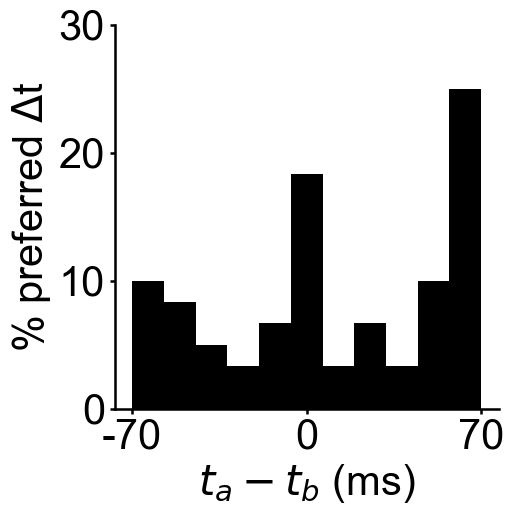

In [671]:
x_valid = np.arange(-70,75,5)
test = np.histogram(x_valid[np.argmax(y_all,1)],bins = 11)
plt.bar(test[1][0:-1], (test[0]/np.sum(test[0])*100),width=test[1][1]-test[1][0],  align='edge', color = 'k')
plt.ylim(0,30)
plt.xticks([-70,0,70], labels = ['-70','0','70'])
plt.xlabel('$\Delta$t (ms)')
plt.ylabel('% preferred $\Delta$t')
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.xlabel('$t_{a}-t_{b}$ (ms)')
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\pref_stim_phase.pdf', bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


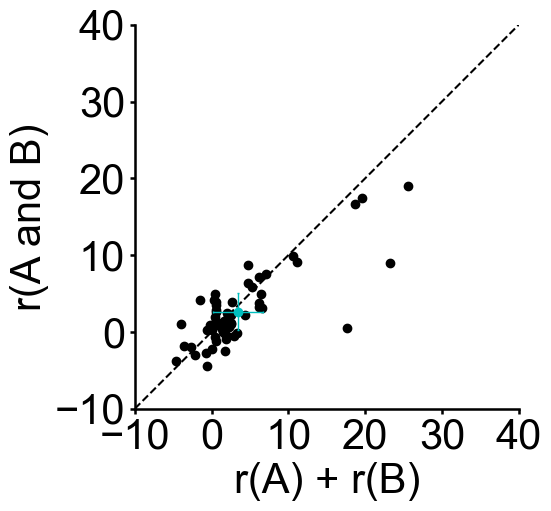

In [630]:
# for each cell, plot the change in firing rate in the simultaneous (delta t = 0) stimulation condition for (A and B) and (A) + (B)
plt.plot(y_combine_all[:,simul_index], y_all[:,simul_index], 'ko', zorder = 1)
plt.errorbar(np.mean(y_combine_all[:,simul_index]), np.mean(y_all[:,simul_index]), xerr = cint_y_combined[1]-cint_y_combined[0], yerr = cint_y[1]-cint_y[0], fmt = 'o', capsize = 1, elinewidth = 1, capthick = 1, zorder = 10, color = 'c')
#plt.plot(mov_mean_y_combine_all[:,simul_index], mov_mean_y_all[:,simul_index], 'ko', zorder = 1)
#plt.errorbar(np.mean(mov_mean_y_combine_all[:,simul_index]), np.mean(mov_mean_y_all[:,simul_index]), xerr = cint_y_combined[1]-cint_y_combined[0], yerr = cint_y[1]-cint_y[0], fmt = 'o', capsize = 1, elinewidth = 1, capthick = 1, zorder = 10, color = 'c')
plt.ylim(-10,40)
plt.xlim(-10,40)
plt.plot([-10,40],[-10,40],'k--')
plt.xticks(np.arange(-10,50,10))
plt.yticks(np.arange(-10,50,10))
plt.ylabel('r(A and B)')
plt.xlabel('r(A) + r(B)')
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\summation_summary.pdf', bbox_inches = 'tight')

In [631]:
# perform a significance test to determine whether firing rates are significantly higher or lower than predicted by the sum of individual spots
scipy.stats.ttest_1samp(y_combine_all[:,simul_index]-y_all[:,simul_index],0)

Ttest_1sampResult(statistic=array([1.68275018]), pvalue=array([0.09770882]))

meta NOT subset; don't know how to subset; dropped


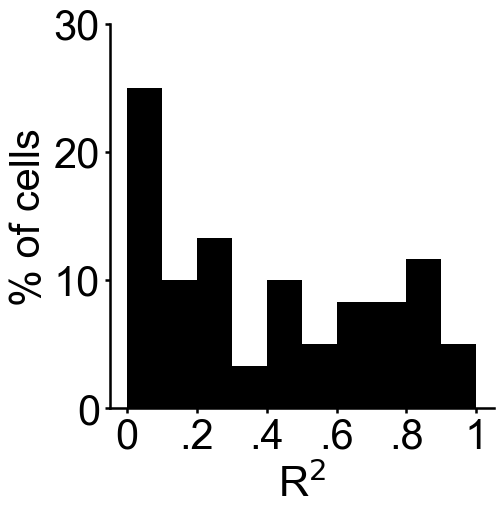

In [635]:
# plot a histogram of r-squared values 
hist_pref = np.histogram(r_sq, bins = np.arange(0,1.1,.1))
plt.bar(np.arange(0,1,.1), (hist_pref[0]/np.sum(hist_pref[0]))*100, width = .1, align = 'edge', color = 'k')
plt.xticks(np.arange(0,1.1,.2), labels = ['0','.2','.4','.6','.8','1'])
plt.ylim(0,25)
plt.yticks([0,10,20,30])
plt.ylabel('% of cells')
plt.xlabel('R$^2$')
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\rsquared_summary.pdf', bbox_inches = 'tight')

In [81]:
max_resp_by_cell = np.max(mov_mean_y_all,1)

meta NOT subset; don't know how to subset; dropped


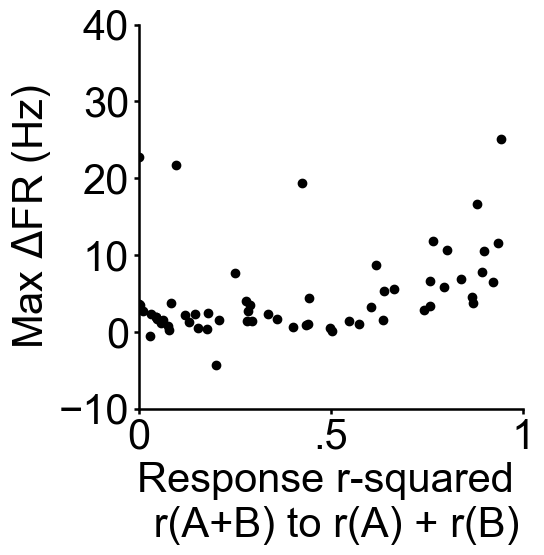

In [672]:
plt.plot(r_sq, max_resp_by_cell, 'ko')
plt.xlim(0,1)
plt.xticks([0,.5,1], labels = ['0', '.5', '1'])
plt.yticks([-10,0,10,20,30,40])
plt.xlabel('Response r-squared \n r(A+B) to r(A) + r(B)')
plt.ylabel('Max $\Delta$FR (Hz)')
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\rsquared_by_max_FR_summary.pdf', bbox_inches = 'tight')

Cell 80 r-squared = 0.8022149261071922
Cell 160 r-squared = 0.9351524416113124
Cell 474 r-squared = 0.6170578710189651


meta NOT subset; don't know how to subset; dropped


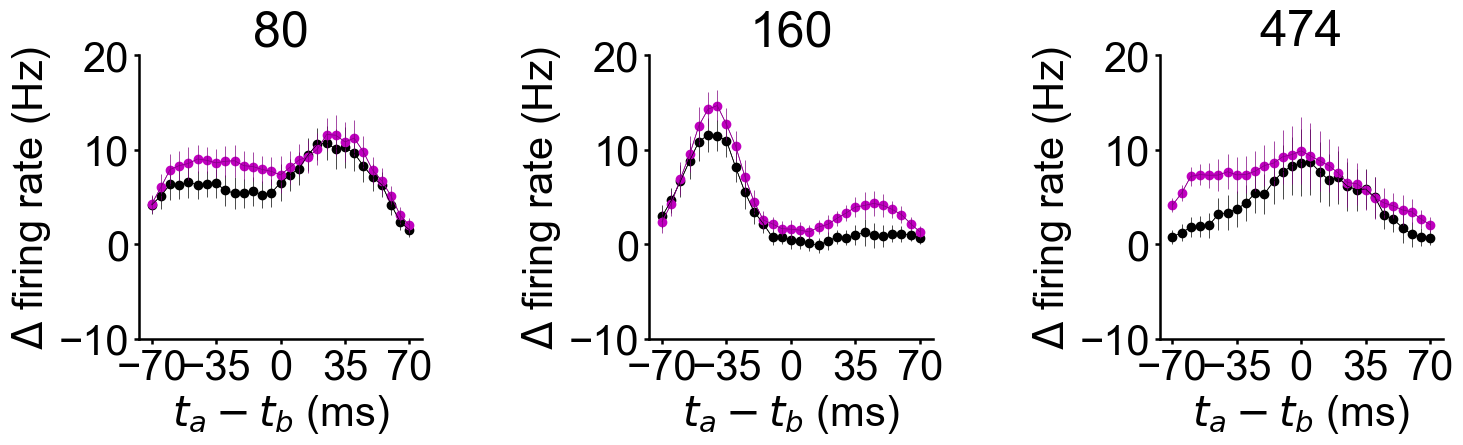

In [531]:
plt.figure(figsize = (30,30))
for cell_n, cell in enumerate([80,160,474]):
    plt.subplot(1,5,cell_n+1)
    plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_latencies_two_spot, font_size = 30)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]
    print('Cell ' + str(cell) + ' r-squared = ' + str(r_sq[resp_idx][0]))
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\example_cell_summation_prediction.pdf', bbox_inches = 'tight')

Cell 80 r-squared = 0.8022149261071922
Cell 160 r-squared = 0.9351524416113124
Cell 474 r-squared = 0.6170578710189651


meta NOT subset; don't know how to subset; dropped


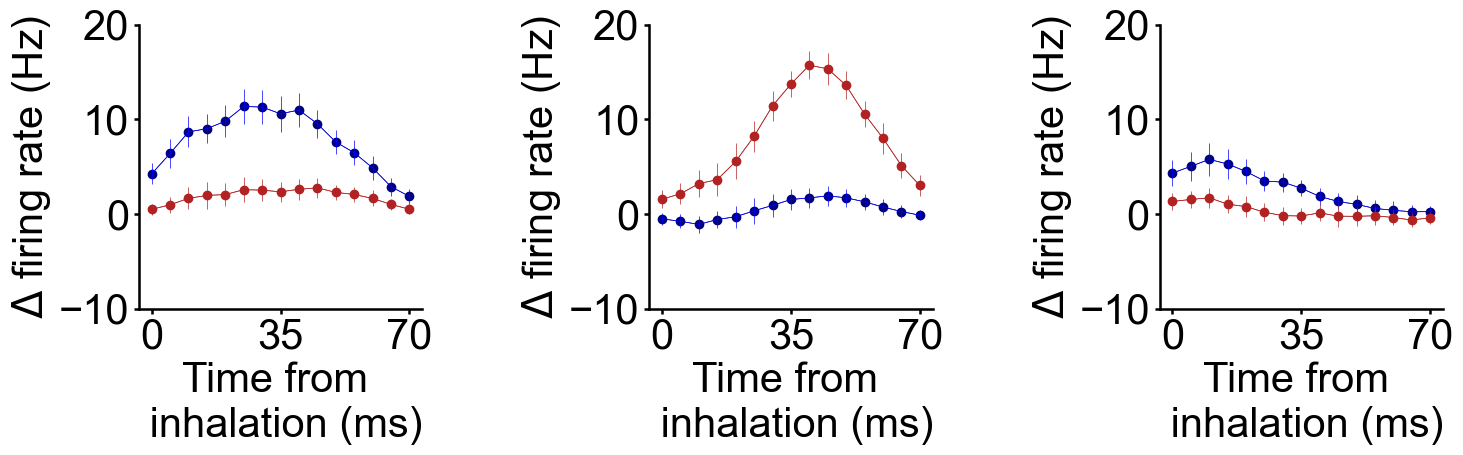

In [534]:
plt.figure(figsize = (30,30))
for cell_n, cell in enumerate([80,160,474]):
    plt.subplot(1,5,cell_n+1)
    plot_individual_spot_tuning(cell, baseline_sub_psth_by_trial, n_trials, n_latencies_single_spot, font_size = 30)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]
    print('Cell ' + str(cell) + ' r-squared = ' + str(r_sq[resp_idx][0]))
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig2\example_cell_single_spot_responses.pdf', bbox_inches = 'tight')

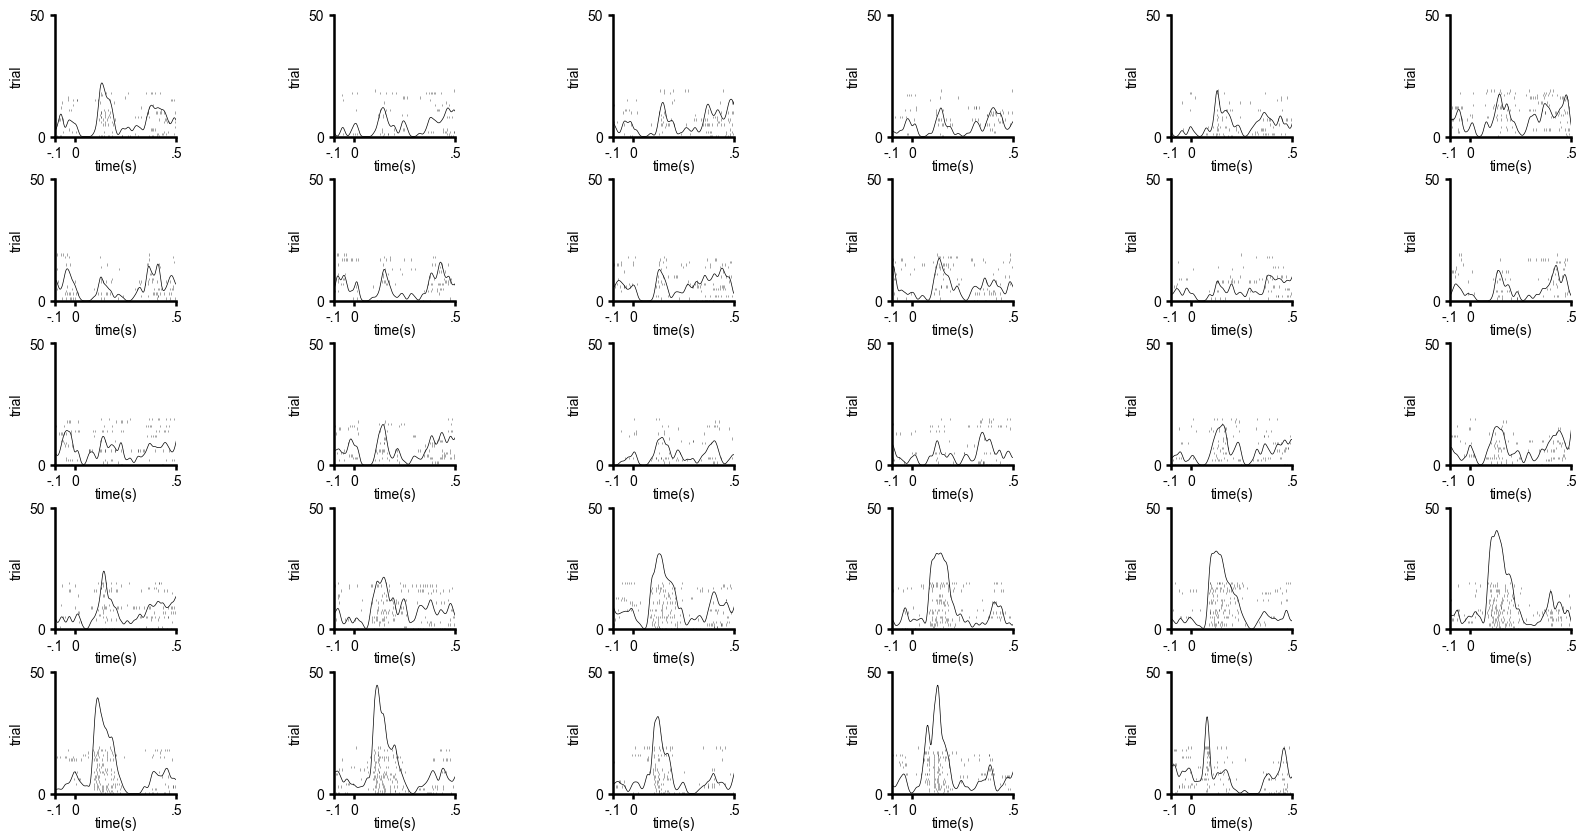

In [114]:
PSTH_timepoints = np.arange(-1,2,.002)
stim_list = indices
fig = plt.figure(figsize=(20,20))
fontsize = 10
cell = 15
mouse = 0
ax = plt.gca()
plt.axis('off')
tn = 0
for i in stim_list:
    ax = plt.subplot(10,6,tn+1)
    ax.set_ylabel('trial', fontsize = fontsize)
    ax.set_xlabel('time(s)', fontsize = fontsize, labelpad = -1)
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    ax.eventplot(reclist[0]['trial_type_raster'][cell][i],color = color, alpha = .5, linewidth = .5);
    ax.plot(PSTH_timepoints, np.mean(reclist[0]['trial_type_psth'][cell][i],0), color = color, linewidth = .5)
    fig.add_subplot(ax)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    plt.xlim(-.1, .2)
    plt.ylim(0,50)
    plt.xticks([-.1,  0, .5], labels = ['-.1', '0', '.5'])
    plt.yticks([0,50], labels = ['0', '50'])
    right_side = ax. spines["right"]
    right_side. set_visible(False)
    top_side = ax. spines["top"]
    top_side. set_visible(False)
    ratio = .5
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    PGanalysis.axis_fixer(ratio = 1)
    tn+=1

In [145]:
single_spot_indices

array([44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

IndexError: index 470 is out of bounds for axis 0 with size 132

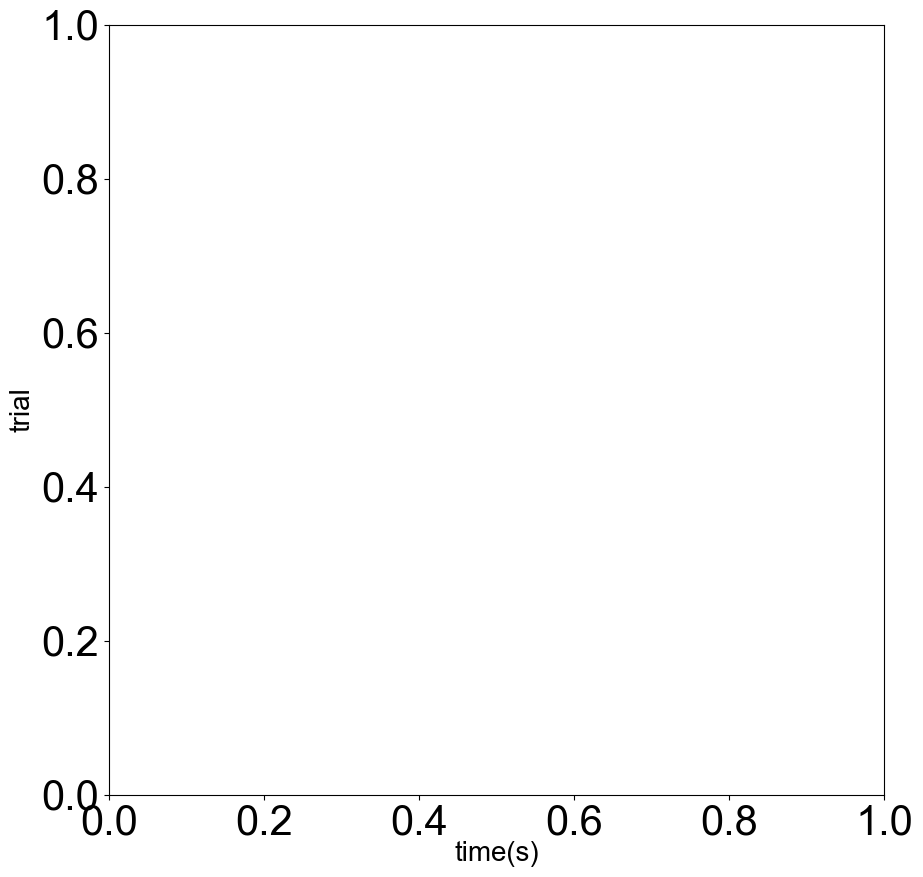

In [476]:
PSTH_timepoints = np.arange(-1,2,.002)
stim_list = np.flipud(single_spot_indices)
fig = plt.figure(figsize=(10,10))
fontsize = 20
cell = 470
mouse = 0
ax = plt.gca()
tn = 0
j = np.arange(0,20)
offset = 0
for i in stim_list:
    ax = plt.gca()
    ax.set_ylabel('trial', fontsize = fontsize)
    ax.set_xlabel('time(s)', fontsize = fontsize, labelpad = -1)
    if i<=14:
        color = 'k'
    else:
        color = 'k'
    ax.eventplot(reclist[0]['trial_type_raster'][cell][i],lineoffsets = j,color = color, alpha = 1, linewidth = 1);
    ax.plot(PSTH_timepoints, np.mean(reclist[0]['trial_type_psth'][cell][i],0)+offset, color = color, linewidth = 1)
    if i<=44:
        plt.plot([(.005*(i-30)),(.005*(i-30))+.02],[offset,offset],'b')
    if i>44:
        plt.plot([(.005*(i-32))-(.005*14),((.005*(i-32))+.02)-.005*14],[offset,offset],'r')
    ax.set_yticks([])
        
    # fig.add_subplot(ax)
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(fontsize) 
    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(fontsize) 
    # plt.xlim(-.1, .2)
    # plt.ylim(0,50)
    # plt.xticks([-.1,  0, .5], labels = ['-.1', '0', '.5'])
    # plt.yticks([0,50], labels = ['0', '50'])
    # right_side = ax. spines["right"]
    # right_side. set_visible(False)
    # top_side = ax. spines["top"]
    # top_side. set_visible(False)
    # ratio = .5
    # xleft, xright = ax.get_xlim()
    # ybottom, ytop = ax.get_ylim()
    # ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    PGanalysis.axis_fixer(ratio = 2)
    #tn+=1
    plt.xlim(-.1,.3)
    j+=20
    offset+=20

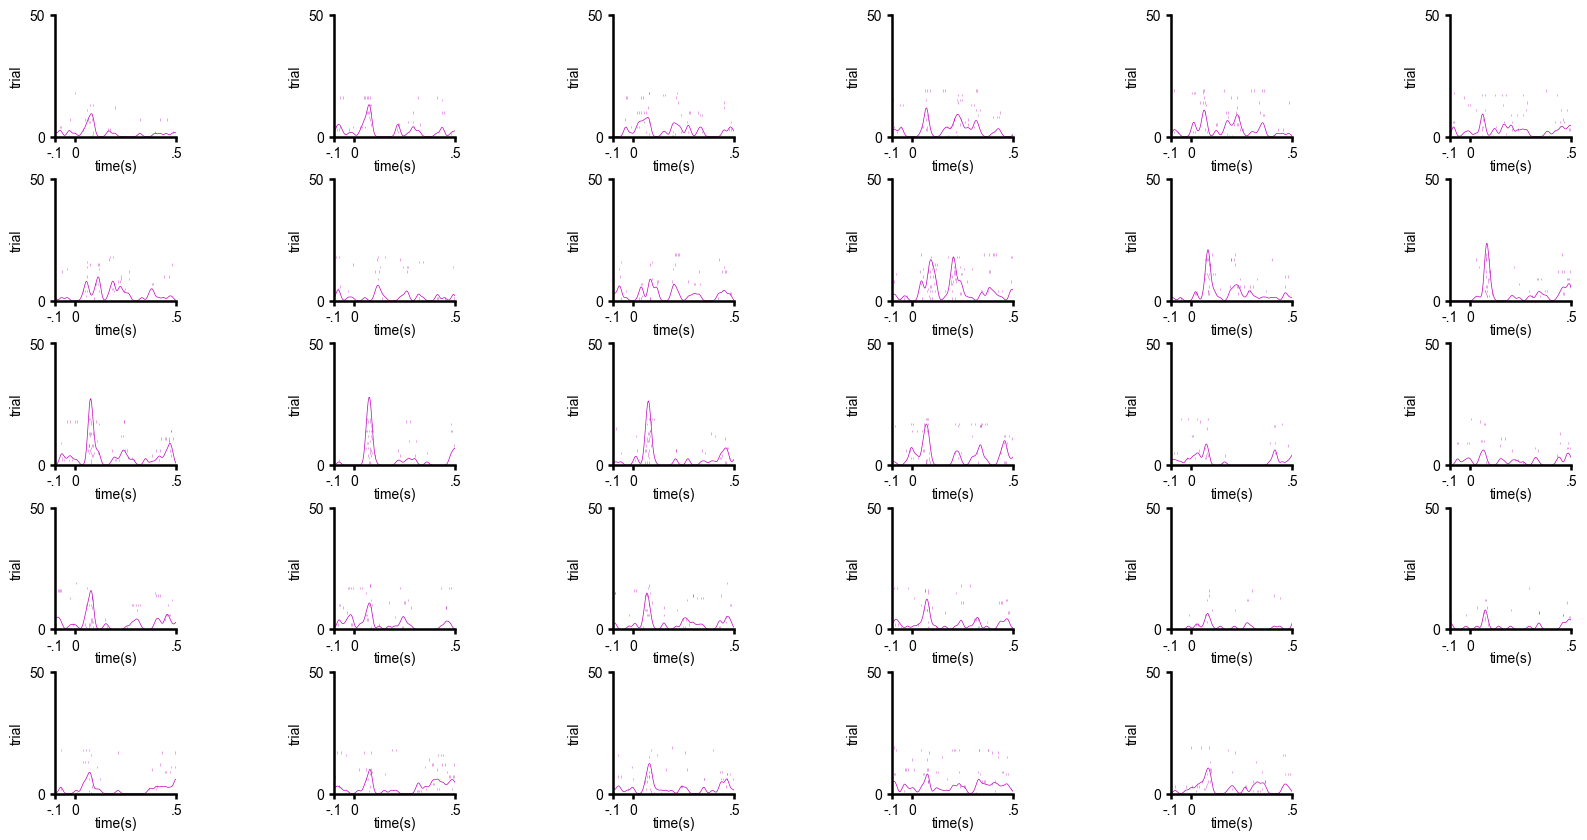

In [35]:
PSTH_timepoints = np.arange(-1,2,.002)
stim_list = single_spot_indices
fig = plt.figure(figsize=(20,20))
fontsize = 10
cell = 81
mouse = 0
ax = plt.gca()
plt.axis('off')
tn = 0
for i in stim_list:
    ax = plt.subplot(10,6,tn+1)
    ax.set_ylabel('trial', fontsize = fontsize)
    ax.set_xlabel('time(s)', fontsize = fontsize, labelpad = -1)
    if i<=14:
        color = 'g'
    else:
        color = 'm'
    ax.eventplot(reclist[0]['trial_type_raster'][cell][i],color = color, alpha = .5, linewidth = .5);
    ax.plot(PSTH_timepoints, np.mean(reclist[0]['trial_type_psth'][cell][i],0), color = color, linewidth = .5)
    fig.add_subplot(ax)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    plt.xlim(-.1, .2)
    plt.ylim(0,50)
    plt.xticks([-.1,  0, .5], labels = ['-.1', '0', '.5'])
    plt.yticks([0,50], labels = ['0', '50'])
    right_side = ax. spines["right"]
    right_side. set_visible(False)
    top_side = ax. spines["top"]
    top_side. set_visible(False)
    ratio = .5
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    PGanalysis.axis_fixer(ratio = 1)
    tn+=1